### HW5 for Fixed-income Quantitative Trading
** Xingyue Huang (N14034682) **

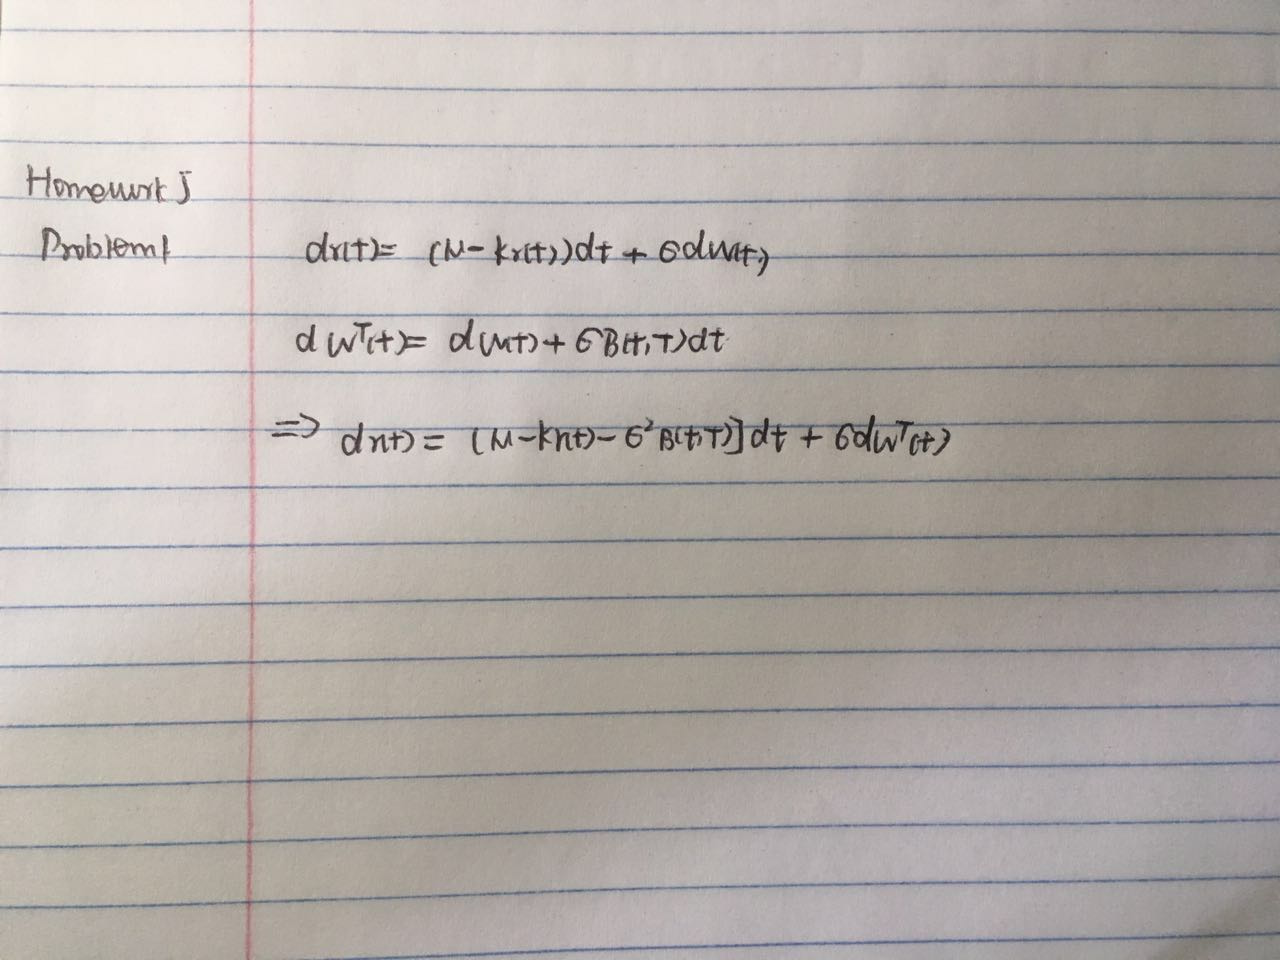

In [1]:
# Solution to Question 1
from IPython.display import Image
Image(filename='hw5_q1.jpeg')

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import leastsq
import statsmodels.api as sm
import statsmodels.formula.api as smf

# read CMT file into pandas dataframe
df = pd.read_excel('CMT-all.xlsx')
df = df.set_index('Date')
df = df.loc['2007-01-01':,] # select data from 2007 on
df = df.dropna() # remove nan
print df.head(), '\n' # print first five rows of data

              1M    3M    6M    1Y    2Y    3Y    5Y    7Y   10Y   20Y   30Y
Date                                                                        
2007-01-02  4.79  5.07  5.11  5.00  4.80  4.71  4.68  4.68  4.68  4.87  4.79
2007-01-03  4.84  5.05  5.09  4.98  4.76  4.69  4.66  4.66  4.67  4.85  4.77
2007-01-04  4.80  5.04  5.07  4.95  4.71  4.63  4.61  4.61  4.62  4.81  4.72
2007-01-05  4.81  5.05  5.09  4.98  4.76  4.68  4.65  4.65  4.65  4.84  4.74
2007-01-08  4.87  5.08  5.13  5.01  4.78  4.70  4.66  4.66  4.66  4.84  4.74 



In [2]:
# obtain beta1, beta2 and beta3
def fit(p, lamda, x): 
    a,b,c = p
    return a+b*(1-np.exp(-lamda*x))/(lamda*x)+c*((1-np.exp(-lamda*x))/(lamda*x)-np.exp(-lamda*x))
def error(p, lamda, x, y):
    return fit(p, lamda, x)-y

term = np.array([1,3,6,12,24,36,60,84,120,240,360])
p0 = [1/2]*3
lamda = 0.0495 # assume an initial lamda

beta1 = []
beta2 = []
beta3 = []

for i in range(df.shape[0]):
    y1 = df.iloc[i,:].values
    plsq = leastsq(error, p0, args=(term,lamda,y1))
    beta1.append(plsq[0][0])
    beta2.append(plsq[0][1])
    beta3.append(plsq[0][2])

In [3]:
## Step1: fit AR(1) to beta1, beta2 and beta3
beta1_pre = beta1[:2517]
beta1_post = beta1[1:2518]
beta2_pre = beta2[:2517]
beta2_post = beta2[1:2518]
beta3_pre = beta3[:2517]
beta3_post = beta3[1:2518]

results1 = sm.OLS(beta1_post,sm.add_constant(beta1_pre)).fit()
results2 = sm.OLS(beta2_post,sm.add_constant(beta2_pre)).fit()
results3 = sm.OLS(beta3_post,sm.add_constant(beta3_pre)).fit()
print 'OLS Summary for beta1 AR(1): \n', results1.summary()
print 'OLS Summary for beta2 AR(1): \n', results2.summary()
print 'OLS Summary for beta3 AR(1): \n', results3.summary()

OLS Summary for beta1 AR(1): 
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 4.523e+05
Date:                Tue, 16 May 2017   Prob (F-statistic):               0.00
Time:                        01:23:54   Log-Likelihood:                 3258.1
No. Observations:                2517   AIC:                            -6512.
Df Residuals:                    2515   BIC:                            -6500.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0105 

In [4]:
# calculate half-times
coef1 = results1.params[1]
HL1 = np.log(0.5)/(np.log(coef1)*260)
coef2 = results2.params[1]
HL2 = np.log(0.5)/(np.log(coef2)*260)
coef3 = results3.params[1]
HL3 = np.log(0.5)/(np.log(coef3)*260)
print 'Half-lives for beta1:', HL1
print 'Half-lives for beta2:', HL2
print 'Half-lives for beta3:', HL3

Half-lives for beta1: 0.955034707063
Half-lives for beta2: 0.755180470598
Half-lives for beta3: 0.438486921184


In [5]:
results1.params

array([ 0.01053045,  0.99721242])

In [6]:
#step2:Compute RMSE for each day in the sample
def error1(p,lamda,x,y):
    global g
    g = fit(p,lamda,x)-y
    return fit(p,lamda,x)-y
RMSE = []
for i in range(df.shape[0]):
    y1 = df.iloc[i,:].values
    plsq = leastsq(error1, p0, args=(term,lamda,y1))
    sums = np.mean(g**2)**0.5
    RMSE.append(sums)
    
print RMSE[0:5]
print sorted(RMSE)[::-1][:5] # find the five larges RMSE
days = list(map(lambda x: RMSE.index(x), sorted(RMSE)[::-1][:5]))
dates = list(map(lambda x: df.index[x], days))
print days
print dates

[0.10712496900270833, 0.092415874067210982, 0.10003601511938455, 0.099739901820923585, 0.095515561366409318]
[0.35850780414517158, 0.29814487406835471, 0.2866398074580464, 0.28376742048367209, 0.27989768345650384]
[160, 435, 452, 455, 434]
[Timestamp('2007-08-20 00:00:00'), Timestamp('2008-09-24 00:00:00'), Timestamp('2008-10-20 00:00:00'), Timestamp('2008-10-23 00:00:00'), Timestamp('2008-09-23 00:00:00')]


In [7]:
# calculate RSS of fitted models
intercept1 = results1.params[0]
intercept2 = results2.params[0]
intercept3 = results3.params[0]
RS = []
data1=pd.DataFrame(index=df.index,columns=df.columns)
for i in days:
    beta_i1=((((beta1[i]*coef1+intercept1)*coef1+intercept1)*coef1+intercept1)*coef1+intercept1)*coef1+intercept1
    beta_i2=((((beta2[i]*coef2+intercept2)*coef2+intercept2)*coef2+intercept2)*coef2+intercept2)*coef2+intercept2
    beta_i3=((((beta3[i]*coef3+intercept3)*coef3+intercept3)*coef3+intercept3)*coef3+intercept3)*coef3+intercept3
    p1=[beta_i1,beta_i2,beta_i3]
    y_fit=fit(p1,lamda,term)
    data1.iloc[i+5,:]=np.array(y_fit)
    residual = np.sum((y_fit-df.iloc[i+5,:])**2)
    RS.append(residual)
print(RS)

#calculate RSS of random walk
RS_r=[]
for i in days:
    residual = np.sum((df.iloc[i+5,:]-df.iloc[i+4,:])**2)
    RS_r.append(residual)
print(RS_r)

[7.463287489251881, 0.7239731029047707, 1.1524491836466988, 1.7001423630366754, 0.5513361701363833]
[0.6016, 0.2528999999999998, 0.012900000000000014, 0.15189999999999992, 1.2612999999999994]


Conclusion: We can see from the RSS under two methods that forecasts under random walk assumption are more accurate.